In [42]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd


In [43]:
# ---------------------------
# 1. Utility Functions
# ---------------------------
def set_seed(seed=42):
    """Set random seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

# Paths
base_path = "/kaggle/input/impulse/Impulse/EEG_Data"
train_path = os.path.join(base_path, "train_data")
val_path = os.path.join(base_path, "validation_data")
test_path = os.path.join(base_path, "test_data")

class_mapping = {
    "Complex_Partial_Seizures": 1,
    "Electrographic_Seizures": 2,
    "Video_detected_Seizures_with_no_visual_change_over_EEG": 3,
    "Normal": 0
}

def load_labeled_data(data_path, class_mapping):
    data, labels = [], []
    for class_name, label in class_mapping.items():
        class_folder = os.path.join(data_path, class_name)
        if os.path.exists(class_folder):
            for file in os.listdir(class_folder):
                if file.endswith(".npy"):
                    sample = np.load(os.path.join(class_folder, file))
                    data.append(sample)
                    labels.append(label)
    return np.array(data), np.array(labels)

def load_unlabeled_data(data_path):
    data, filenames = [], []
    for file in os.listdir(data_path):
        if file.endswith(".npy"):
            sample = np.load(os.path.join(data_path, file))
            data.append(sample)
            filenames.append(file)
    return np.array(data), filenames

In [44]:
# Data Loading
train_data, train_labels = load_labeled_data(train_path, class_mapping)
val_data, val_labels = load_labeled_data(val_path, class_mapping)
test_data, test_filenames = load_unlabeled_data(test_path)

In [45]:
def normalize_data(data):
    mean = data.mean(axis=(0, 2), keepdims=True)
    std = data.std(axis=(0, 2), keepdims=True) + 1e-8
    return ((data - mean) / std).astype(np.float32)

train_data = normalize_data(train_data)
val_data = normalize_data(val_data)
test_data = normalize_data(test_data)

In [46]:
# ---------------------------
# 2. Dataset Definition
# ---------------------------
class EEGDataset1D(Dataset):
    def __init__(self, data, labels=None, augment=False):
        self.data = torch.tensor(data, dtype=torch.float32)
        print(f"Permuted data shape: {self.data.shape}")  # Debug: Confirm shape
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None
        self.augment = augment # Augmentation flag

    def __len__(self):
        return len(self.data)  # Number of samples

    def __getitem__(self, idx):
        # Retrieve sample and (optionally) add noise
        sample = self.data[idx]
        if self.augment:
            sample = self.add_noise(sample.numpy())
        if self.labels is not None:
            return sample, self.labels[idx]  # Return sample with label
        return sample  # Return only sample for test data

    def add_noise(self, sample, noise_level=0.05):
        # Add Gaussian noise for augmentation
        noise = np.random.randn(*sample.shape) * noise_level
        return torch.tensor(sample + noise, dtype=torch.float32)





In [47]:
train_dataset = EEGDataset1D(train_data, train_labels, augment=True)
val_dataset = EEGDataset1D(val_data, val_labels)
test_dataset = EEGDataset1D(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


Permuted data shape: torch.Size([5608, 19, 500])
Permuted data shape: torch.Size([1403, 19, 500])
Permuted data shape: torch.Size([779, 19, 500])


In [48]:
def initialize_weights(module):
    if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

In [63]:

class Simple1DCNN(nn.Module):
    def __init__(self, input_channels, input_length, num_classes):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.batch_norm = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()

        dummy_input = torch.zeros(1, input_channels, input_length)
        self.flattened_size = self._get_flattened_size(dummy_input)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)

        self.apply(initialize_weights)

    def _get_flattened_size(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.batch_norm(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [64]:
input_channels = train_data.shape[1]  # Features dimension (19)
input_length = train_data.shape[2]    # Sequence length (500)
num_classes = len(class_mapping)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple1DCNN(input_channels, input_length, num_classes).to(device)


In [65]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)



In [59]:
for batch in train_loader:
    data, labels = batch
    print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")
    break


Data shape: torch.Size([32, 19, 500]), Labels shape: torch.Size([32])


In [66]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=7):
    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for data, labels in val_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model_weights.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load("best_model_weights.pth"))
    return model

In [74]:
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)


Epoch 1/30, Train Loss: 14.3522, Train Acc: 0.9609, Val Loss: 9.7381, Val Acc: 0.9316
Epoch 2/30, Train Loss: 13.1181, Train Acc: 0.9568, Val Loss: 9.4341, Val Acc: 0.9323
Epoch 3/30, Train Loss: 12.4059, Train Acc: 0.9583, Val Loss: 9.8637, Val Acc: 0.9316
Epoch 4/30, Train Loss: 13.8104, Train Acc: 0.9627, Val Loss: 10.1942, Val Acc: 0.9301
Epoch 5/30, Train Loss: 13.0596, Train Acc: 0.9599, Val Loss: 10.8484, Val Acc: 0.9280
Epoch 6/30, Train Loss: 14.5026, Train Acc: 0.9608, Val Loss: 9.8424, Val Acc: 0.9301
Epoch 7/30, Train Loss: 11.9523, Train Acc: 0.9593, Val Loss: 10.4585, Val Acc: 0.9316
Epoch 8/30, Train Loss: 13.1789, Train Acc: 0.9617, Val Loss: 9.9730, Val Acc: 0.9316
Epoch 9/30, Train Loss: 11.9049, Train Acc: 0.9679, Val Loss: 10.0416, Val Acc: 0.9316
Early stopping triggered.


<ipython-input-66-b673d6e798c5>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_weights.pth"))


Validation Classification Report:
                          precision    recall  f1-score   support

                  Normal       0.92      0.96      0.94       696
Complex Partial Seizures       0.95      0.89      0.92       549
 Electrographic Seizures       0.96      0.98      0.97       137
 Video-detected Seizures       0.84      1.00      0.91        21

                accuracy                           0.93      1403
               macro avg       0.92      0.96      0.93      1403
            weighted avg       0.93      0.93      0.93      1403

Balanced Accuracy Score: 0.9556
ROC AUC Score (OvR): 0.9896


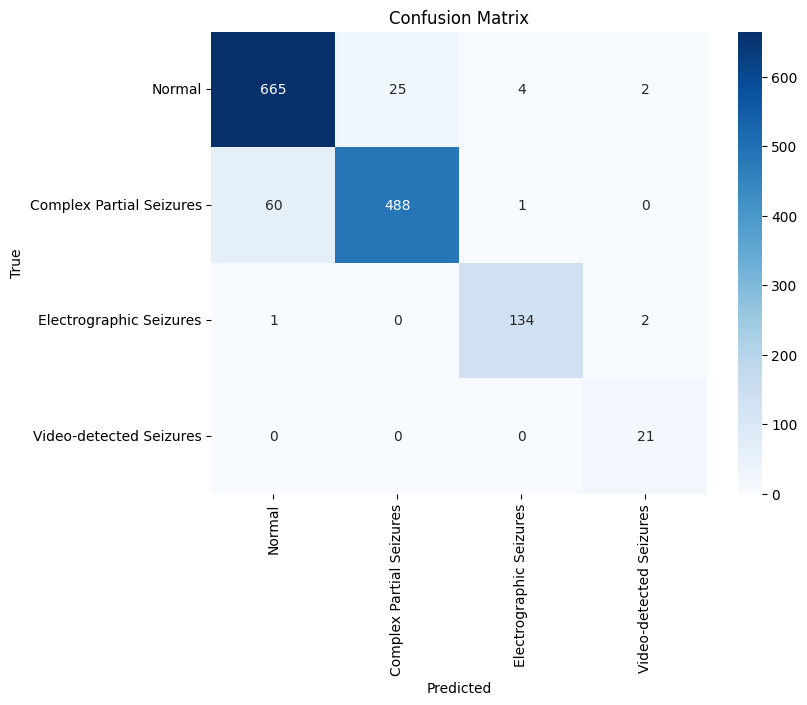

In [75]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# 6. Evaluation
# ---------------------------
def evaluate_model(model, val_loader, class_names):
    model.eval()
    val_preds, val_labels = [], []
    val_probs = []

    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = outputs.argmax(1).cpu().numpy()

            val_preds.extend(preds)
            val_probs.extend(probs)
            val_labels.extend(labels.cpu().numpy())

    # Classification Report
    print("Validation Classification Report:")
    print(classification_report(val_labels, val_preds, target_names=class_names))

    # Balanced Accuracy Score
    balanced_acc = balanced_accuracy_score(val_labels, val_preds)
    print(f"Balanced Accuracy Score: {balanced_acc:.4f}")

    # ROC AUC Score (One-vs-Rest)
    try:
        roc_auc = roc_auc_score(val_labels, val_probs, multi_class='ovr')
        print(f"ROC AUC Score (OvR): {roc_auc:.4f}")
    except ValueError:
        print("ROC AUC Score could not be computed (ensure probabilities are provided and labels are multi-class).")

    # Confusion Matrix
    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ["Normal", "Complex Partial Seizures", "Electrographic Seizures", "Video-detected Seizures"]
evaluate_model(trained_model, val_loader, class_names)


In [56]:
# ---------------------------
# 7. Save Test Predictions
# ---------------------------
def generate_test_predictions(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            preds = outputs.argmax(1).cpu().numpy()
            predictions.extend(preds)
    return predictions

test_predictions = generate_test_predictions(trained_model, test_loader)

def save_sorted_predictions(filenames, predictions, output_file="test_predictions_cnn1d_best1.csv"):
    results = pd.DataFrame({"Filename": filenames, "Predicted Label": predictions})
    results["Numeric Order"] = results["Filename"].str.extract(r'(\d+)').astype(int)
    results = results.sort_values(by="Numeric Order").drop(columns=["Numeric Order"])
    results.to_csv(output_file, index=False)
    print(f"Test predictions saved to {output_file}")

save_sorted_predictions(test_filenames, test_predictions)

Test predictions saved to test_predictions_cnn1d_best1.csv


In [17]:
!pip install lime

In [18]:
import numpy as np
import torch
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns


In [19]:
trained_model.eval()
device = torch.device("cpu")
trained_model.to(device)

Simple1DCNN(
  (conv1): Conv1d(19, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc1): Linear(in_features=8000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [20]:
def predict_fn(inputs):
    """
    A wrapper for the trained PyTorch model that outputs probabilities.
    Reshapes the input to match the model's expected input shape.
    """
    batch_size = inputs.shape[0]
    inputs = inputs.reshape(batch_size, 19, 500)  # Reshape to (batch_size, num_channels, seq_length)
    print("Input shape for model (before forward):", inputs.shape)  # Debugging print

    # Convert to torch tensor
    inputs = torch.tensor(inputs, dtype=torch.float32).to(device)

    # Model inference
    with torch.no_grad():
        logits = trained_model(inputs)  # Pass through the model
        print("Logits shape:", logits.shape)  # Debugging print
        probabilities = torch.softmax(logits, dim=1).cpu().numpy()  # Convert to probabilities
        print("Probabilities shape:", probabilities.shape)  # Debugging print

    return probabilities

In [21]:
explainer = LimeTabularExplainer(
    train_data.reshape(train_data.shape[0], -1),  # Flatten the EEG data (samples x features)
    mode="classification",
    feature_names=[f"Channel_{i}" for i in range(train_data.shape[1])],
    class_names=["Normal", "Complex Partial Seizures", "Electrographic Seizures", "Video-detected Seizures"],
    discretize_continuous=False
)


In [22]:
def explain_sample(sample, model, explainer):
    """
    Explains the model's prediction for a single sample using LIME.
    """
    sample_flat = sample.reshape(-1)  # Flatten the sample
    explanation = explainer.explain_instance(
        sample_flat,
        predict_fn,  # The prediction function defined earlier
        num_features=train_data.shape[1],  # Number of EEG channels
        top_labels=len(class_names)  # Number of classes to explain
    )
    return explanation

In [23]:
# Collect feature importance for each class
importance_by_class = defaultdict(list)

In [24]:
# # Generate explanations for a subset of the validation data
# for i in range(100):  # Adjust this number based on computation limits
#     sample = val_data[i]
#     label = val_labels[i]

#     explanation = explain_sample(sample, trained_model, explainer)
#     class_idx = explanation.top_labels[0]  # Predicted class

#     # Append the importance values for each channel
#     for feature, importance in explanation.local_exp[class_idx]:
#         channel_idx = feature // 500  # Map flattened feature index to channel index
#         if channel_idx < len(feature_names):  # Ensure it's within valid range
#             importance_by_class[class_idx].append((channel_idx, importance))

# # Aggregate and find top 3 channels for each class
# top_channels_by_class = {}
# for class_idx, feature_importances in importance_by_class.items():
#     # Aggregate importance values for each feature (within the 19-channel scope)
#     aggregated = defaultdict(float)
#     for feature, importance in feature_importances:
#         aggregated[feature] += importance

#     # Sort by importance and select the top 3
#     sorted_channels = sorted(aggregated.items(), key=lambda x: x[1], reverse=True)[:3]
#     top_channels_by_class[class_idx] = [feature_names[ch] for ch, _ in sorted_channels]




In [ ]:
# # Optional: Visualize top channel contributions
# for class_idx, feature_importances in importance_by_class.items():
#     aggregated = defaultdict(float)
#     for feature, importance in feature_importances:
#         aggregated[feature] += importance

#     # Sort by importance
#     sorted_importances = sorted(aggregated.items(), key=lambda x: x[1], reverse=True)
#     channels, importances = zip(*sorted_importances)

#     # Plot
#     plt.figure(figsize=(10, 6))
#     plt.barh([feature_names[ch] for ch in channels], importances, color="skyblue")
#     plt.xlabel("Importance")
#     plt.ylabel("EEG Channels")
#     plt.title(f"Channel Importance for Class: {class_names[class_idx]}")
#     plt.gca().invert_yaxis()
#     plt.show()

In [26]:
# Ensure we sample from all classes in the validation set
def sample_from_each_class(data, labels, num_per_class=5):
    """
    Ensure at least `num_per_class` samples are included for each class.
    """
    sampled_data, sampled_labels = [], []
    for class_idx in range(len(class_names)):
        # Get indices of all samples for the current class
        class_indices = np.where(labels == class_idx)[0]
        
        # Randomly sample `num_per_class` or fewer if not enough samples
        selected_indices = np.random.choice(class_indices, size=min(num_per_class, len(class_indices)), replace=False)
        
        # Add the samples and labels
        sampled_data.append(data[selected_indices])
        sampled_labels.append(labels[selected_indices])
    
    # Concatenate samples from all classes
    return np.concatenate(sampled_data, axis=0), np.concatenate(sampled_labels, axis=0)

# Sample 1 instance per class (or fewer if not enough samples exist)
sampled_data, sampled_labels = sample_from_each_class(val_data, val_labels, num_per_class=50)

# Collect feature importance for each class
importance_by_class = defaultdict(list)


In [27]:
# Generate feature names for LIME based on channels
num_channels = 19
sequence_length = 500
feature_names = [f"Channel_{i}" for i in range(num_channels)]

# Function to map flattened indices back to channels
def map_flat_index_to_channel(flat_index, sequence_length):
    """
    Maps a flattened feature index to the corresponding EEG channel.
    """
    return flat_index // sequence_length

# Collect feature importance for each class
importance_by_class = defaultdict(list)

# Generate explanations for the sampled data
for i in range(len(sampled_data)):
    sample = sampled_data[i]
    label = sampled_labels[i]

    explanation = explain_sample(sample, trained_model, explainer)

    # Iterate over all classes in the explanation
    for class_idx in range(len(class_names)):
        # Map feature indices to channels and append importance
        for flat_index, importance in explanation.local_exp[class_idx]:
            channel = map_flat_index_to_channel(flat_index, sequence_length)
            importance_by_class[class_idx].append((channel, importance))

# Aggregate and find top 3 channels for each class
top_channels_by_class = {}
for class_idx, feature_importances in c.items():
    # Aggregate importance values for each channel
    aggregated = defaultdict(float)
    for channel, importance in feature_importances:
        aggregated[channel] += importance

    # Sort by importance and select the top 3
    cc = sorted(aggregated.items(), key=lambda x: x[1], reverse=True)[:3]
    top_channels_by_class[class_idx] = [f"Channel_{ch}" for ch, _ in sorted_channels]

# Print results
for class_idx, top_channels in top_channels_by_class.items():
    print(f"Top 3 channels for class {class_names[class_idx]}: {top_channels}")


Input shape for model (before forward): (5000, 19, 500)
Logits shape: torch.Size([5000, 4])
Probabilities shape: (5000, 4)
Input shape for model (before forward): (5000, 19, 500)
Logits shape: torch.Size([5000, 4])
Probabilities shape: (5000, 4)
Input shape for model (before forward): (5000, 19, 500)
Logits shape: torch.Size([5000, 4])
Probabilities shape: (5000, 4)
Input shape for model (before forward): (5000, 19, 500)
Logits shape: torch.Size([5000, 4])
Probabilities shape: (5000, 4)
Input shape for model (before forward): (5000, 19, 500)
Logits shape: torch.Size([5000, 4])
Probabilities shape: (5000, 4)
Input shape for model (before forward): (5000, 19, 500)
Logits shape: torch.Size([5000, 4])
Probabilities shape: (5000, 4)
Input shape for model (before forward): (5000, 19, 500)
Logits shape: torch.Size([5000, 4])
Probabilities shape: (5000, 4)
Input shape for model (before forward): (5000, 19, 500)
Logits shape: torch.Size([5000, 4])
Probabilities shape: (5000, 4)
Input shape for 

In [28]:
# Print results
for class_idx, top_channels in top_channels_by_class.items():
    print(f"Top 3 channels for class {class_names[class_idx]}: {top_channels}")


Top 3 channels for class Normal: ['Channel_0', 'Channel_3', 'Channel_17']
Top 3 channels for class Complex Partial Seizures: ['Channel_8', 'Channel_14', 'Channel_2']
Top 3 channels for class Electrographic Seizures: ['Channel_11', 'Channel_4', 'Channel_7']
Top 3 channels for class Video-detected Seizures: ['Channel_12', 'Channel_6', 'Channel_10']


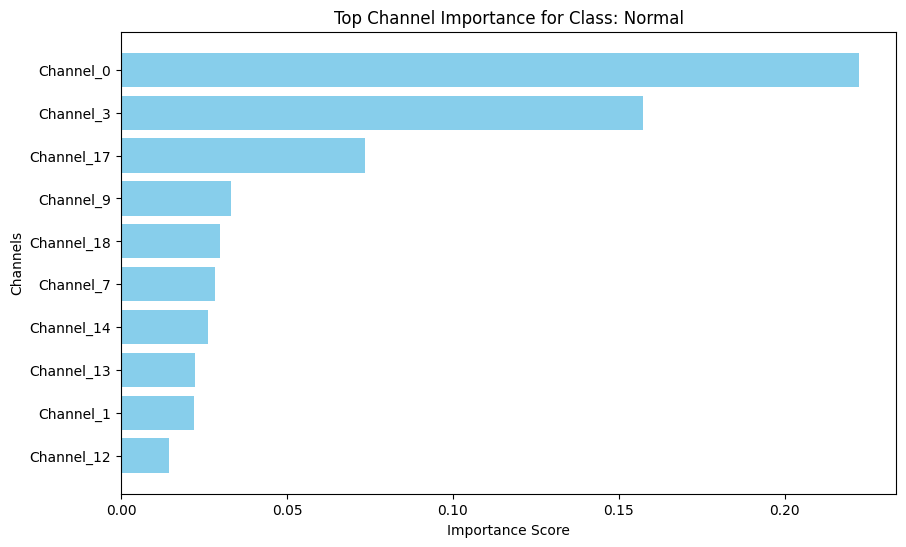

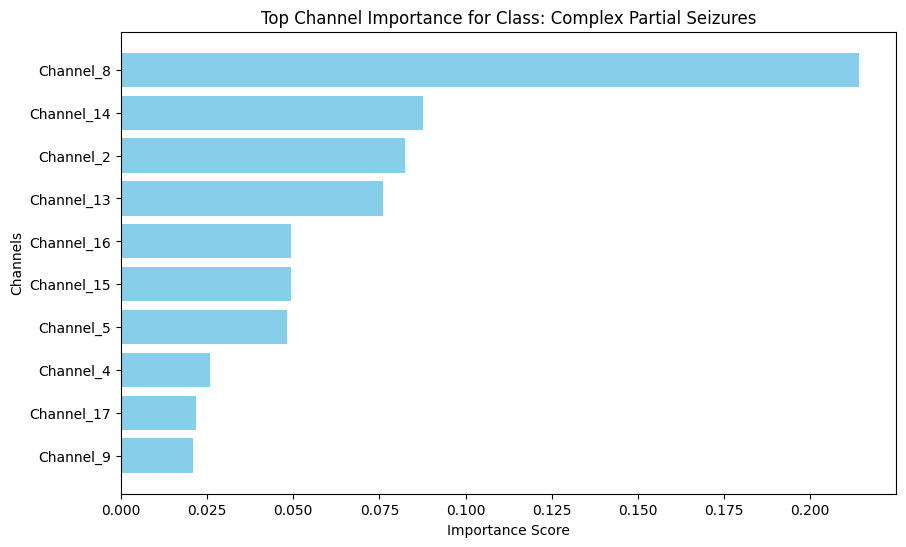

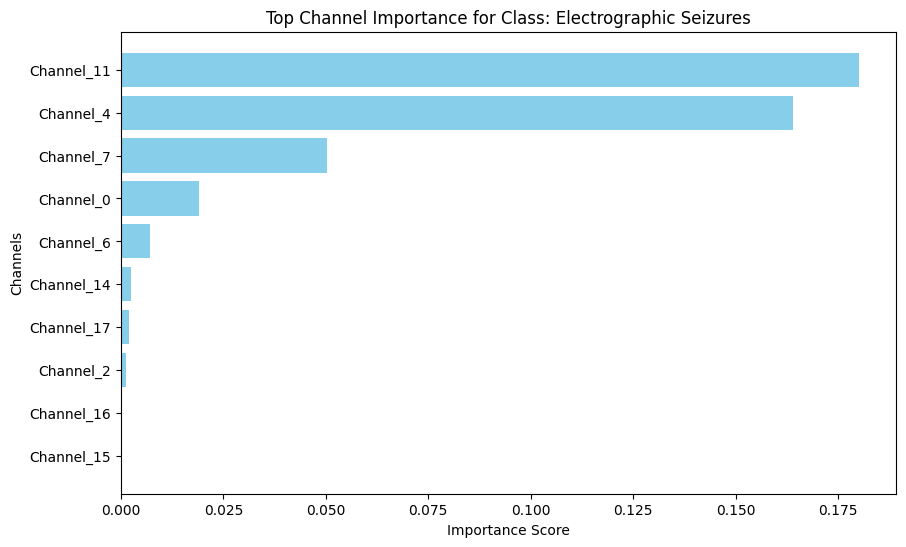

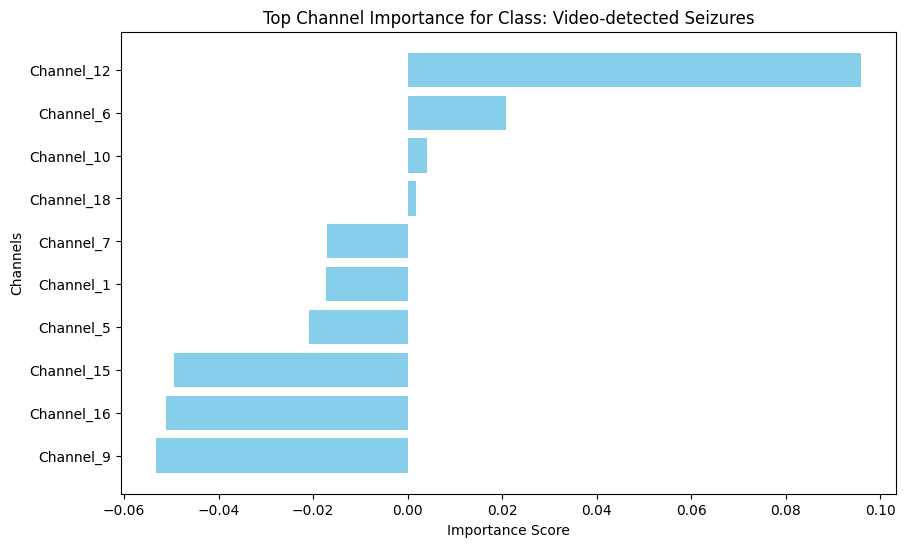

Top 3 channels for class Normal: ['Channel_0', 'Channel_3', 'Channel_17']
Top 3 channels for class Complex Partial Seizures: ['Channel_8', 'Channel_14', 'Channel_2']
Top 3 channels for class Electrographic Seizures: ['Channel_11', 'Channel_4', 'Channel_7']
Top 3 channels for class Video-detected Seizures: ['Channel_12', 'Channel_6', 'Channel_10']


In [38]:
aggregated_importance = defaultdict(list)

for class_idx, feature_importances in importance_by_class.items():
    # Aggregate importance values for each channel
    aggregated = defaultdict(float)
    for channel, importance in feature_importances:
        aggregated[channel] += importance

    # Sort by importance
    sorted_channels = sorted(aggregated.items(), key=lambda x: x[1], reverse=True)
    aggregated_importance[class_idx] = sorted_channels
    top_channels_by_class[class_idx] = [f"Channel_{ch}" for ch, _ in sorted_channels[:3]]

# Plotting the importance for each class
for class_idx, sorted_channels in aggregated_importance.items():
    plot_channel_importance(class_idx, sorted_channels, class_names)

# Print top 3 channels
for class_idx, top_channels in top_channels_by_class.items():
    print(f"Top 3 channels for class {class_names[class_idx]}: {top_channels}")